# Discovering Symbolic Models from Deep Learning with Inductive Biases 

Bernardo Ricci

[GitHub project](https://github.com/BernardoRicci/symbolic_deep_learning) 

The task was to put into practice and modify the model suggested in the article '[Discovering Symbolic Models from Deep Learning with Inductive Biases](https://arxiv.org/abs/2006.11287)'.  The objective is to use an inductively biased GNN to derive a symbolic representation of the interaction between pairs of particles.
Simulations of systems of interacting particles are generated to create the dataset. Each event is saved as a graph, with each node representing a particle and its properties as features.
This GNN does Message Passing by aggregating the edges in an overall message, then, using a second MLP, it trains on the value of the accelerations. It does this by using the prior outputs from the first MLP to calculate the edges between pairs of nodes that hold the information on the interaction.
The inductive bias consists in treating the edges/messages as if they really represent the forces and is therefore imposed through the aggregation operation.
At hte end we use the PySR package to perform the symbolic regression on the single interactions calculated by the first MLP.

Set 'RunColab = True' if you run this code in Google Colab, otherwise you should install 'julia' for the final part of the program [from the official site](https://julialang.org/downloads/)
(It is needed to use PySR).

IMPORTANT
Check to have GPU, otherwise: Runtime >> change Runtime type >> GPU

# IMPORTANT PRELIMINARY PASSAGES - READ CAREFULLY

Set 'RunColab = True' if you run this code in Google Colab, otherwise you should install 'julia' for the final part of the program [from the official site](https://julialang.org/downloads/)
(It is needed to use PySR).

Check to have GPU, otherwise: Runtime >> change Runtime type >> GPU

In [1]:
import torch
# Check to have GPU, otherwise change Runtime type
torch.ones(1).cuda()
RunColab = False

In [2]:
%%capture
%%shell

set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.5"
export JULIA_PKG_PRECOMPILE_AUTO=0
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  echo "Installing PyCall.jl..."
  julia -e 'using Pkg; Pkg.add("PyCall"); Pkg.build("PyCall")'
  julia -e 'println("Success")'
  
fi

In [3]:
%pip install -Uq pysr pytorch_lightning

Note: you may need to restart the kernel to use updated packages.


In [4]:
import julia
from julia import Julia
if RunColab == False:
    julia.install()

julia = Julia(compiled_modules=False, threads='auto')
from julia import Main
from julia.tools import redirect_output_streams

redirect_output_streams()

[ Info: Julia version info


Julia Version 1.9.1
Commit 147bdf428cd (2023-06-07 08:27 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
      Ubuntu 22.04.2 LTS
  uname: Linux 5.19.0-45-generic #46~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Jun 7 15:06:04 UTC 20 x86_64 x86_64
  CPU: AMD Ryzen 7 5800H with Radeon Graphics: 
                 speed         user         nice          sys         idle          irq
       #1-16  3257 MHz     124155 s        113 s      31626 s    2780032 s          0 s
  Memory: 13.496692657470703 GB (6063.95703125 MB free)
  Uptime: 18552.91 sec
  Load Avg:  1.36  1.17  1.23
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, znver3)
  Threads: 1 on 16 virtual cores
Environment:
  MATHEMATICA_HOME = /usr/local/Wolfram/Mathematica/13.0
  HOME = /home/bernardo
  SNAP_LIBRARY_PATH = /var/lib/snapd/lib/gl:/var/lib/snapd/lib/gl32:/var/lib/snapd/void
  MANDATORY_PATH = /usr/share/gconf/ubuntu.mandatory.path
  DEFAULTS_PATH = /usr/share/gconf/ubuntu.default.path
  TERM = xterm-col

[ Info: Julia executable: /snap/julia/80/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /bin/python3
│     libpython: /usr/lib/x86_64-linux-gnu/libpython3.10.so.1.0
│ Python:
│     python: /bin/python3
└     libpython: 


# Data Generation

## Import packages

In [5]:
import numpy as np
import pandas as pd
import os
import torch
from torch.autograd import Variable
from tqdm import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.integrate import odeint
from copy import deepcopy as copy
from IPython.display import HTML
from scipy.optimize import minimize

In [6]:
!pip install celluloid
version_nums = torch.__version__.split('.')
version_nums[-1] = '0' + version_nums[-1][1:]
os.environ['TORCH'] = '.'.join(version_nums)
!pip install --upgrade torch-scatter -f https://pytorch-geometric.com/whl/torch-${TORCH}.html && pip install --upgrade torch-sparse -f https://pytorch-geometric.com/whl/torch-${TORCH}.html && pip install --upgrade torch-geometric


from celluloid import Camera
from torch import nn
from torch.functional import F
from torch.optim import Adam
from torch_geometric.nn import MetaLayer, MessagePassing
from torch_geometric.data import Data, DataLoader

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cu117.html
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://pytorch-geometric.com/whl/torch-1.13.0+cu117.html
Defaulting to user installation because normal site-packages is not writeable


Download of the files:

- simulation.py: contains the code for simulations
- models.py: contains the code with GNN models


In [7]:
!wget https://raw.githubusercontent.com/BernardoRicci/symbolic_deep_learning/master/models.py -O models.py
!wget https://raw.githubusercontent.com/BernardoRicci/symbolic_deep_learning/master/simulate.py -O simulate.py

import models
import simulate

--2023-06-25 15:47:12--  https://raw.githubusercontent.com/BernardoRicci/symbolic_deep_learning/master/models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13860 (14K) [text/plain]
Saving to: ‘models.py’

models.py           100%[===================>]  13,54K  --.-KB/s    in 0,01s   

2023-06-25 15:47:13 (1,35 MB/s) - ‘models.py’ saved [13860/13860]

--2023-06-25 15:47:13--  https://raw.githubusercontent.com/BernardoRicci/symbolic_deep_learning/master/simulate.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9879 (9,6K) [te

## Create the simulation

Let's generate $n_s$ simulations of a particle system that evolves over time by choosing the interaction potential and saving at every instant some features for each particle with the individual acceleration components. Each particle is associated with a node of the graph, with $n_{features}$ features.
The acceleration values ​​of each particle are used as a label to train the net.


In [8]:
# Number of simulations to run
ns = 10000
# Potential (see below for options)
sim = 'spring'
# Number of nodes
n = 4
# Dimension
dim = 2
# Number of time steps
nt = 1000

#Standard simulation sets:
n_set = [4, 8]
sim_sets = [
 {'sim': 'r1', 'dt': [5e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'r2', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]},
 {'sim': 'spring', 'dt': [1e-2], 'nt': [1000], 'n': n_set, 'dim': [2, 3]}, 
 {'sim': 'charge', 'dt': [1e-3], 'nt': [1000], 'n': n_set, 'dim': [2, 3]}
]

#Select the hand-tuned dt value for a smooth simulation
# (since scales are different in each potential):
dt = [ss['dt'][0] for ss in sim_sets if ss['sim'] == sim][0]

title = '{}_n={}_dim={}_nt={}_dt={}'.format(sim, n, dim, nt, dt)
print('Running on', title)

Running on spring_n=4_dim=2_nt=1000_dt=0.01


In [9]:
from simulate import SimulationDataset
s = SimulationDataset(sim, n=n, dim=dim, nt=nt//2, dt=dt)
base_str = './'
data_str = title
s.simulate(ns)

data = s.data
s.data.shape

(10000, 500, 4, 6)

Plot of a simulation example.

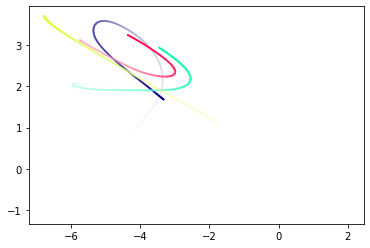

In [10]:
s.plot(0, animate=True, plot_size=False)

## Dataset preparation 

Let's generate the dataset remembering that the goal is to train on the accelerations

In [11]:
accel_data = s.get_acceleration()
X = torch.from_numpy(np.concatenate([s.data[:, i] for i in range(0, s.data.shape[1], 5)]))
y = torch.from_numpy(np.concatenate([accel_data[:, i] for i in range(0, s.data.shape[1], 5)])) 

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

# Used Models:

The network used is a custom GNN (see models.py) where:

A first MLP takes as input the pairs of nodes of the graph, has three hidden layers of 300 neurons and outputs the message between the two nodes. I want that the returned message represents the interaction between the nodes. To do this I have experimented different methods:

- "Bottleneck" model, in which the output will have a dimension equal to that in which the particles live;
 
- "L1" model, a GN with 100 message components using a L1 regularization loss term on the messages with a weight of $10^{−2}$;

- "KL" model, a GN with 100 message components using the Kullback-Leibler (KL) divergence with respect to Gaussian prior;

- "PM" model, composed of 5 consecutive layers of 300, 450, 600, 450, 300 neurons and an outgoing message of 100 neurons, with regularization L1;

- "CUSTOM" model, denoting with $X$ the output of the 1st linear dense layer, 2 independent linear layers are then instantiated to respectively perform linear transformations over $\frac{1}{1+ReLU(X)}$ and $\frac{1}{(1+ReLU(X))^2}$,  where the unit is added to avoid 0 division errors.


For each of this model I can apply three different losses:
 - Mean Squared Error (MSE);
 - Mean Absolute Error (MAE);
 - Huber Loss (HUBER);

In [13]:
from models import make_packer, make_unpacker, get_edge_index, OGN, varOGN, PM_GN, CUST_GN
edge_index = get_edge_index(n, sim) 

## Hyperparameters:

In [14]:
class HP:
  def __init__(self, n_feat, model_type, loss_type = 'MAE', reg = 'without_reg', aggr = 'add', hidden_dim = 300, msg_dim = 100, out_dim = 2):
    self.model_type = model_type       # model_type = 'Bottleneck', 'L1', 'KL', 'PM', 'CUST'
    self.n_f = n_feat
    self.reg = reg
    self.loss_type = loss_type         # loss_type = 'MSE', 'MAE', 'HUBER'
    self.aggr = aggr
    self.hidden_dim = hidden_dim
    self.msg_dim = msg_dim
    self.dim = out_dim
    
    if self.model_type == 'Bottleneck': 
      self.msg_dim = 2
    elif self.model_type == 'L1': 
      self.reg = 'L1'
      self.msg_dim = 100
    elif self.model_type == 'KL': 
      self.reg = 'KL'
      self.msg_dim = 100 
    elif self.model_type == 'PM': 
      self.reg = 'L1'
      self.msg_dim = 100
    elif self.model_type == 'CUST': 
      self.reg = 'L1'
      self.msg_dim = 100

### Here you can modify 'model_type' and 'loss_type' to personalize your training

In [15]:
mod = HP(n_feat = data.shape[3], model_type = 'CUST', loss_type = 'HUBER')


In [16]:
if mod.model_type == 'PM': 
  ogn = PM_GN(mod.n_f, mod.msg_dim, mod.dim, dt=0.1, hidden=mod.hidden_dim, edge_index=get_edge_index(n, sim), aggr=mod.aggr).cuda()
elif mod.model_type == 'CUST':
  ogn = CUST_GN(mod.n_f, mod.msg_dim, mod.dim, dt=0.1, hidden=mod.hidden_dim, edge_index=get_edge_index(n, sim), aggr=mod.aggr).cuda()
elif mod.model_type == 'KL': 
  ogn = varOGN(mod.n_f, mod.msg_dim, mod.dim, dt=0.1, hidden=mod.hidden_dim, edge_index=get_edge_index(n, sim), aggr=mod.aggr).cuda()  
elif mod.model_type == 'Bottleneck' or mod.model_type == 'L1': 
  ogn = OGN(mod.n_f, mod.msg_dim, mod.dim, dt=0.1, hidden=mod.hidden_dim, edge_index=get_edge_index(n, sim), aggr=mod.aggr).cuda()
else:
  raise NotImplementedError("'model_type' choosen doesn't exist!")


messages_over_time = []
ogn=ogn.cuda()

# Set up the training

## Dataloader

Let's organize into data loader creating mini-batches of graphs

In [17]:
batch =  int(64 * (4 / n)**2) # = 64 for n=4
trainloader = DataLoader(
    [Data(
        Variable(X_train[i]),
        edge_index=edge_index,
        y=Variable(y_train[i])) for i in range(len(y_train))],
    batch_size=batch,
    shuffle=True
)

testloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in range(len(y_test))],
    batch_size=1024,
    shuffle=True
)

validationloader = DataLoader(
    [Data(
        X_val[i],
        edge_index=edge_index,
        y=y_val[i]) for i in range(len(y_val))],
    batch_size=batch,
    shuffle=True
)

/home/bernardo/.local/lib/python3.10/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Losses and Regularizations:

The final loss is MSE, MAE, or HUBER summed up with the regularization, L1 or KL (or nothing in the case of Bottleneck).

In [18]:
def new_loss(self, g, m, augment=True):  
    base_loss = self.loss(g, m.loss_type)
    s1 = g.x[self.edge_index[0]]
    s2 = g.x[self.edge_index[1]]
    if m.reg == 'L1':
      m12 = self.message(s1, s2)
      regularization = 1e-2
      #Want one loss value per row of g.y:
      normalized_l05 = torch.sum(torch.abs(m12))
      return base_loss + regularization * batch * normalized_l05 / n**2 * n
    if m.reg == 'KL':
      regularization = 1
      #Want one loss value per row of g.y:
      tmp = torch.cat([s1, s2], dim=1) 
      raw_msg = self.msg_fnc(tmp)
      mu = raw_msg[:, 0::2]
      logvar = raw_msg[:, 1::2]
      full_kl = torch.sum(torch.exp(logvar) + mu**2 - logvar)/2.0
      return base_loss + regularization * batch * full_kl / n**2 * n
       
    else:
      return base_loss

Let's define the initial learning rate and the ADAM optimizer.
[OneCycleLR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html) reduces learning rate according to the 1cycle learning rate policy.
In contrast to many other learning rate schedulers, the learning rate is not only decreased over the training process. Instead, the learning rate increases from an initial learning rate to some maximum learning rate and then decreases again.

In [19]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, OneCycleLR

init_lr = 1e-3

opt = torch.optim.Adam(ogn.parameters(), lr=init_lr, weight_decay=1e-8)

total_epochs = 100
                       
batch_per_epoch = int(1000*10 / (batch/32.0))

sched = OneCycleLR(opt, max_lr=init_lr,
                   steps_per_epoch=len(trainloader),
                   epochs=total_epochs, final_div_factor=1e5)


batch_per_epoch

epoch = 0

Run = f"{sim}_{mod.model_type}_{mod.loss_type}"


## Organize the recording of messages over time
This is for fitting the forces, and extracting laws.

On this set are calculate the messages to export (with get_messages()):

In [20]:
np.random.seed(0)
test_idxes = np.random.randint(0, len(X_test), 1000)

#Record messages over test dataset here:
newtestloader = DataLoader(
    [Data(
        X_test[i],
        edge_index=edge_index,
        y=y_test[i]) for i in test_idxes],
    batch_size=len(X_test),
    shuffle=False
)

## Record messages from model
'get_messages' calculate the messages, to save them together with the relative distances between two nodes.

In [21]:
def get_messages(ogn, m):

    def get_message_info(tmp, m):
        ogn.cpu()

        s1 = tmp.x[tmp.edge_index[0]]
        s2 = tmp.x[tmp.edge_index[1]]
        tmp = torch.cat([s1, s2], dim=1)
        if m.reg == 'KL':
            raw_msg = ogn.msg_fnc(tmp)
            mu = raw_msg[:, 0::2]
            logvar = raw_msg[:, 1::2]

            m12 = mu
        else:
            m12 = ogn.msg_fnc(tmp)

        all_messages = torch.cat((
            s1,
            s2,
            m12), dim=1)
        if dim == 2:          
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d vx%d vy%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(m.msg_dim)]
        elif dim == 3:
            columns = [elem%(k) for k in range(1, 3) for elem in 'x%d y%d z%d vx%d vy%d vz%d q%d m%d'.split(' ')]
            columns += ['e%d'%(k,) for k in range(m.msg_dim)]


        return pd.DataFrame(
            data=all_messages.cpu().detach().numpy(),
            columns=columns
        )

    msg_info = []
    for i, g in enumerate(newtestloader):
        msg_info.append(get_message_info(g, m))

    msg_info = pd.concat(msg_info)
    msg_info['dx'] = msg_info.x1 - msg_info.x2
    msg_info['dy'] = msg_info.y1 - msg_info.y2
    if dim == 2:
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2
        )
    elif dim == 3:
        msg_info['dz'] = msg_info.z1 - msg_info.z2
        msg_info['r'] = np.sqrt(
            (msg_info.dx)**2 + (msg_info.dy)**2 + (msg_info.dz)**2
        )
    
    return msg_info

In [22]:
recorded_models = []

## Training Loop

So let's resume all the hyperparameters and characteristics of the model that is going to be trained

In [23]:
print('Model:',mod.model_type)
print('Loss:',mod.loss_type)
print('ogn:',ogn)
print('Regularization:',mod.reg,'\n')
print('# features:',mod.n_f)
print('Total epochs:',total_epochs)
print('Simulation:',sim)
print('Nodes (particles in simulation):',n)
print('# Simulations:',ns)
print('Dimension:',dim)
print('Batch:',batch)

Model: CUST
Loss: HUBER
ogn: CUST_GN()
Regularization: L1 

# features: 6
Total epochs: 100
Simulation: spring
Nodes (particles in simulation): 4
# Simulations: 10000
Dimension: 2
Batch: 64


In [24]:
t_loss = []     
t_val_loss = []    

In [25]:
for epoch in tqdm(range(epoch, total_epochs)):
    ogn.cuda()
    tot_loss = 0.0
    tot_val_loss = 0.0
    num_items = 0
    num_items_vali = 0
    #Training
    for ginput in trainloader:
        opt.zero_grad()
        ginput.x = ginput.x.cuda()
        ginput.y = ginput.y.cuda()
        ginput.edge_index = ginput.edge_index.cuda()
        ginput.batch = ginput.batch.cuda()
        loss = new_loss(ogn, ginput, mod)
        (loss/int(ginput.batch[-1]+1)).backward()
        opt.step()
        sched.step()

        tot_loss += loss.item()
        num_items += int(ginput.batch[-1]+1)
        
    #Validation
    for ginput in validationloader:
        ginput.x = ginput.x.cuda()
        ginput.y = ginput.y.cuda()
        ginput.edge_index = ginput.edge_index.cuda()
        ginput.batch = ginput.batch.cuda()
        vali_loss = new_loss(ogn, ginput, mod)       
        tot_val_loss += vali_loss.item()
        num_items_vali += int(ginput.batch[-1]+1) 

    loss_ = tot_loss/num_items
    t_loss.append(loss_)   

    val_loss_ = tot_val_loss / num_items_vali
    t_val_loss.append(val_loss_) 

    cur_msgs = get_messages(ogn, mod)
    cur_msgs['epoch'] = epoch
    cur_msgs['loss'] = loss_
    cur_msgs['val_loss'] = val_loss_
    messages_over_time.append(cur_msgs)
    recorded_models.append(ogn.state_dict())

    print("loss:", loss_, "valid. loss:", val_loss_)

  0%|          | 0/100 [00:00<?, ?it/s]

# Analyze Trained Model

## Best Model
Let's take the model with the lowest validation loss.

In [ ]:
best_val = np.argmin(t_val_loss) 
best_model = recorded_models[best_val]
ogn.load_state_dict(best_model)

<All keys matched successfully>

Let's see the behaviour of the training and validation along the epochs

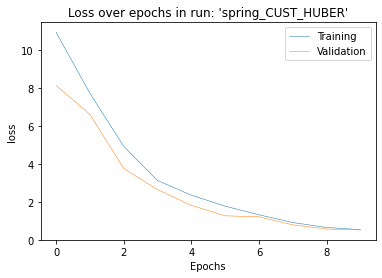

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(len(t_loss)), t_loss, lw = 0.5, label="Training loss")
ax.plot(range(len(t_val_loss)), t_val_loss, lw = 0.5, label = "Validation loss")
#plt.scatter(best_val, t_val_loss[best_val], label = "Best loss")
ax.set_title(f"Loss over epochs in run: '{Run}'")
ax.set_ylabel("Loss")
ax.set_xlabel("Epochs")
plt.legend()
plt.savefig(Run + '_loss.png')
plt.savefig(Run + '_loss.jpeg')
plt.savefig(Run + '_loss.pdf')

## Almost Correct Predictions Error Rate (ACPER) and Almost Correct Predictions Correct Rate (ACPCR)

The ACPCR is the percentage of predictions that is with a certain percentage (treshold) of the true value. It’s about setting an arbitrary range in which values fall in. All of those values contribute to calculating ACPCR.
Essentially, is 1-ACPER (Almost Correct Predictions Error Rate).
The ACPER is the the percentage of predictions that is out of a certain percentage of the true value.

Highest the ACPCR, better the training over the simulation. The opposite for the ACPER.


For this work I assumed a treshold of 2% over the true value.

In [ ]:
def ACPCR(self, dataloader):
    num_batch = 0
    total_acpcr = 0
    th = 0.02
    for batch in dataloader:
        y_true = batch.y
        y_pred = self.just_derivative(batch)
        diff = torch.abs(y_pred - y_true)
        threshold = th * torch.abs(y_true)
        within_threshold = (diff <= threshold)
        batch_acpcr = torch.mean(within_threshold.float())
        total_acpcr += batch_acpcr
        num_batch += 1
    avg_acpcr = total_acpcr / float(num_batch)
    return avg_acpcr, (1-avg_acpcr)


In [ ]:
acpcr_epochs = []
acper_epochs = []

for epoch in tqdm(range(0,len(recorded_models),2)):
      ogn.load_state_dict(recorded_models[epoch])
      acpcr, acper = ACPCR(ogn, testloader)
      acpcr_epochs.append([epoch, acpcr])
      acper_epochs.append([epoch, acper])

acpcr_epochs = np.array(acpcr_epochs)
acper_epochs = np.array(acper_epochs)
best_acpcr, best_acper = ACPCR(ogn, testloader)


print("Almost Correct Predictions Correct Rate:", acpcr)
print("Almost Correct Predictions Error Rate:", acper)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [02:13<00:00, 26.71s/it]


Almost Correct Predictions Correct Rate: tensor(0.1957)
Almost Correct Predictions Error Rate: tensor(0.8043)


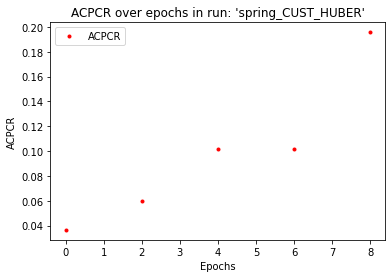

In [ ]:
fig, ax = plt.subplots()
ax.plot(acpcr_epochs[:,0],acpcr_epochs[:,1], '.', color='red', label='ACPCR')
ax.set_ylabel("ACPCR")
ax.set_title(f"ACPCR over epochs in run: '{Run}'")
ax.set_xlabel("Epochs")
plt.legend()
plt.savefig(Run + '_ACPCR.png')
plt.savefig(Run + '_ACPCR.jpeg')
plt.savefig(Run + '_ACPCR.pdf')

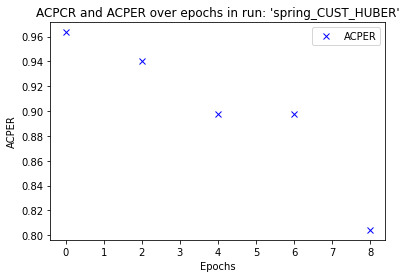

In [ ]:
fig, ax = plt.subplots()
ax.plot(acper_epochs[:,0],acper_epochs[:,1], 'x', color='blue', label='ACPER')
ax.set_ylabel("ACPER")
ax.set_title(f"ACPCR and ACPER over epochs in run: '{Run}'")
ax.set_xlabel("Epochs")
plt.legend()
plt.savefig(Run + '_ACPER.png')
plt.savefig(Run + '_ACPER.jpeg')
plt.savefig(Run + '_ACPER.pdf')

In [ ]:
np.savetxt(Run+'_ACPCR.txt', acpcr_epochs)
np.savetxt(Run+'_ACPER.txt', acper_epochs)

Let's save messages in files

In [ ]:
import pickle as pkl


pkl.dump(messages_over_time,
        open(Run + '_messages_over_time.pkl', 'wb'))
pkl.dump(recorded_models,
        open(Run + '_models_over_time.pkl', 'wb'))

## Analysis 
Now let's analyze the functioning of the network with some plots

### Mean and Standard Deviation

The regularization term added to the loss favors a representation of the message vector in which the information is concentrated in the minimum number of entries possible, setting the others to zero. The initial idea to identify which components are actually relevant is to study their average value and observe which of these do not cancel out.

However this approach would not work, as the mean value of all interactions of a system without external forces would have to be really zero.
I studied the standard deviation of the individual components since the only entries that would result non-zero are those whose value changes from interaction to interaction, since the parameters on which this depends on the pairs of particles taken into consideration.

What I expect is that progressively during training the standard deviation of the entries decreases for most of them, ideally reaching a number of entries with non-zero variance equal to the physical dimension of the system in which the particles live ($D$). Although I haven't always managed to get this exact result, I have observed something very close to this process.

Mean of Messages Components (for Bottleneck is useless since the components are only 2)

In [ ]:
fig1, ax1 = plt.subplots(1,1)
cam = Camera(fig1)
t =  lambda _: tqdm(_)
for i in t(range(0, len(messages_over_time), 1)):
  msgs = copy(messages_over_time[i])
  msg_columns = ['e%d'%(k) for k in range(mod.msg_dim)]
  msg_array = np.array(msgs[msg_columns])
  msg_array = np.mean(msg_array, axis=0)

  plt.title(f"Mean of messages components")
  plt.xlabel("Messages Components")
  plt.ylabel("Mean")
  plt.scatter(range(len(msg_array)), msg_array, color='orange', marker=".")
  cam.snap()
plt.close()
ani = cam.animate()
HTML(ani.to_jshtml())

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:00<00:00, 123.89it/s]


Standar Deviation of Messages Components (for Bottleneck is useless since the components are only 2)

In [ ]:
fig1, ax1 = plt.subplots(1,1)
cam = Camera(fig1)
t =  lambda _: tqdm(_)
for i in t(range(0, len(messages_over_time), 1)):
  msgs = copy(messages_over_time[i])
  msg_columns = ['e%d'%(k) for k in range(mod.msg_dim)]
  msg_array = np.array(msgs[msg_columns])
  msg_array = np.std(msg_array, axis=0)

  plt.title(f"Standard Deviation of messages components")
  plt.xlabel("Messages Components")
  plt.ylabel("Std. Dev.")
  plt.scatter(range(len(msg_array)), msg_array, color='green', marker=".")
  #return fig, ax
  cam.snap()
plt.close()
ani = cam.animate()
HTML(ani.to_jshtml())

100%|██████████| 10/10 [00:00<00:00, 116.59it/s]


Standard Deviation of all messages per Epoch.

Thanks to this plot it's possible to see that Standard Deviation over epochs at a certain point tend to an asymptotic behaviour. It means that most of messages components had sufficient time to go to zero, and it means that the number of epochs choosen is big big enough.

100%|██████████| 10/10 [00:00<00:00, 140.81it/s]


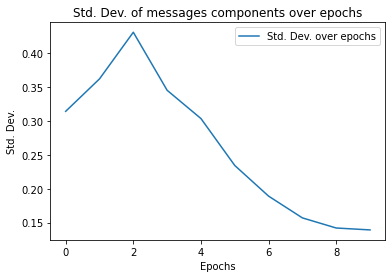

In [ ]:
fig, ax = plt.subplots(1,1)
t =  lambda _: tqdm(_)
plt.title(f"Std. Dev. of messages components over epochs")
plt.xlabel("Epochs")
plt.ylabel("Std. Dev.")
msg_std = []
for i in t(range(0, len(messages_over_time))):
  msgs = copy(messages_over_time[i])
  msg_col = ['e%d'%(k) for k in range(mod.msg_dim)]
  msg_array= np.array(msgs[msg_col])
  msg_std.append(np.std(msg_array))
ax.plot(range(len(messages_over_time)), msg_std, label="Std. Dev. over epochs")
plt.legend()
plt.savefig(Run + '_std.png')
plt.savefig(Run + '_std.jpeg')
plt.savefig(Run + '_std.pdf')

It is then possible to go back to physical forces. Calling $m_1$ and $m_2$ the most relevant components of the message, it is possible to decompose them as a linear combination of the physical force components $F_x$ and $F_y$, as $m_{i} = α_{i, \ x} F_x + α_{i, \ y} F_y + α_{i, \ bias}$

To do this, let's rearrange the components in order of importance, evaluated by the Standard Deviation from the mean value across all edges( for the KL model, I considered the feature with the
largest KL-divergence).

Verification is done by calculating the physical force from the simulation parameters and performing a linear fit for the messages.

In [ ]:
fig, ax = plt.subplots(1, dim, figsize=(4*dim, 4))
cam = Camera(fig)


for i in t(range(0, len(messages_over_time), 1)):
  msgs = copy(messages_over_time[i])

  msgs['bd'] = msgs.r + 1e-2  
  msg_columns = ['e%d'%(k) for k in range(mod.msg_dim)]
  msg_array = np.array(msgs[msg_columns])
  msg_importance = msg_array.std(axis=0)


  most_important = np.argsort(msg_importance)[-dim:]
  msgs_to_compare = msg_array[:, most_important]

 
  msgs_to_compare = (msgs_to_compare - np.average(msgs_to_compare, axis=0)) / np.std(msgs_to_compare, axis=0)

  pos_cols = ['dx', 'dy']
  if dim == 3:
    pos_cols.append('dz')


  if sim == 'spring':
    force_fnc = lambda msg: -(np.array(msg.bd) - 1)[:, None] * np.array(msg[pos_cols]) / np.array(msg.bd)[:, None] # -grad(U) = -(r-1)*(x,y)/r

  elif sim == 'r1':
    force_fnc = lambda msg: np.array(msgs.m1)[:, None] * np.array(msgs.m2)[:, None] * np.array(msg[pos_cols]) / (np.array(msg.bd)[:, None] ** 2) # -grad(U) = m1*m2*(x,y)/r^2

  elif sim == 'r2':
    force_fnc = lambda msg: -2 * np.array(msgs.m1)[:, None] * np.array(msgs.m2)[:, None] * np.array(msg[pos_cols]) / (np.array(msg.bd)[:, None] ** 3) # -grad(U) = m1*m2*(x,y)/r^3

  elif sim == 'charge':
    force_fnc = lambda msg: -np.array(msgs.q1)[:, None] * np.array(msgs.q2)[:, None] * np.array(msg[pos_cols]) / (np.array(msg.bd)[:, None] ** 3) # -grad(U) = m1*m2*(x,y)/r^3 


  expected_forces = force_fnc(msgs)

  def percentile_sum(x):
    x = x.ravel()
    bot = x.min()
    top = np.percentile(x, 90)
    msk = (x>=bot) & (x<=top)
    frac_good = (msk).sum()/len(x)
    return x[msk].sum()/frac_good

  def linear_transformation_2d(alpha):

      lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
      lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

      score = (
          percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
          percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2))
      )/2.0

      return score

  def out_linear_transformation_2d(alpha):
      lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1]) + alpha[2]
      lincomb2 = (alpha[3] * expected_forces[:, 0] + alpha[4] * expected_forces[:, 1]) + alpha[5]

      return lincomb1, lincomb2

  def linear_transformation_3d(alpha):

      lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
      lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
      lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

      score = (
          percentile_sum(np.square(msgs_to_compare[:, 0] - lincomb1)) +
          percentile_sum(np.square(msgs_to_compare[:, 1] - lincomb2)) +
          percentile_sum(np.square(msgs_to_compare[:, 2] - lincomb3))
      )/3.0

      return score

  def out_linear_transformation_3d(alpha):

      lincomb1 = (alpha[0] * expected_forces[:, 0] + alpha[1] * expected_forces[:, 1] + alpha[2] * expected_forces[:, 2]) + alpha[3]
      lincomb2 = (alpha[0+4] * expected_forces[:, 0] + alpha[1+4] * expected_forces[:, 1] + alpha[2+4] * expected_forces[:, 2]) + alpha[3+4]
      lincomb3 = (alpha[0+8] * expected_forces[:, 0] + alpha[1+8] * expected_forces[:, 1] + alpha[2+8] * expected_forces[:, 2]) + alpha[3+8]

      return lincomb1, lincomb2, lincomb3

  if dim == 2:
      min_result = minimize(linear_transformation_2d, np.ones(dim**2 + dim), method='Powell')
  if dim == 3:
      min_result = minimize(linear_transformation_3d, np.ones(dim**2 + dim), method='Powell')
  print(title, mod.model_type, 'gets', min_result.fun/len(msgs))

  for j in range(dim):
    if dim == 3:
        px = out_linear_transformation_3d(min_result.x)[j]
    else:
        px = out_linear_transformation_2d(min_result.x)[j]

    py = msgs_to_compare[:, j]
    ax[j].scatter(px, py,
                  alpha=0.1, s=0.1, color='k')
    ax[j].set_xlabel('Linear combination of forces')
    ax[j].set_ylabel('Message Element %d'%(i+1))

    xlim = np.array([np.percentile(px, q) for q in [10, 90]])
    ylim = np.array([np.percentile(py, q) for q in [10, 90]])
    xlim[0], xlim[1] = xlim[0] - (xlim[1] - xlim[0])*0.05, xlim[1] + (xlim[1] - xlim[0])*0.05
    ylim[0], ylim[1] = ylim[0] - (ylim[1] - ylim[0])*0.05, ylim[1] + (ylim[1] - ylim[0])*0.05

    ax[j].set_xlim(xlim)
    ax[j].set_ylim(ylim)
    
  plt.tight_layout()

  cam.snap()
plt.close()
ani = cam.animate()
HTML(ani.to_jshtml())
        

 10%|█         | 1/10 [00:00<00:02,  4.06it/s]

spring_n=4_dim=2_nt=1000_dt=0.01 CUST gets 0.575837515371817


 20%|██        | 2/10 [00:00<00:01,  4.37it/s]

spring_n=4_dim=2_nt=1000_dt=0.01 CUST gets 0.4026007447419343


 40%|████      | 4/10 [00:00<00:01,  4.96it/s]

spring_n=4_dim=2_nt=1000_dt=0.01 CUST gets 0.30066111811885127
spring_n=4_dim=2_nt=1000_dt=0.01 CUST gets 0.05870851587366174


 60%|██████    | 6/10 [00:01<00:00,  5.38it/s]

spring_n=4_dim=2_nt=1000_dt=0.01 CUST gets 0.05688856336805556
spring_n=4_dim=2_nt=1000_dt=0.01 CUST gets 0.05864996309633608


 80%|████████  | 8/10 [00:01<00:00,  5.49it/s]

spring_n=4_dim=2_nt=1000_dt=0.01 CUST gets 0.057238300464771415
spring_n=4_dim=2_nt=1000_dt=0.01 CUST gets 0.05824604034423828


100%|██████████| 10/10 [00:01<00:00,  5.27it/s]

spring_n=4_dim=2_nt=1000_dt=0.01 CUST gets 0.05689936319986979
spring_n=4_dim=2_nt=1000_dt=0.01 CUST gets 0.056367715906213825


Here we can see the grayscale animation of the message components over time (for Bottleneck is unuseful since the message components are only 2)

In [ ]:
fig2, ax2 = plt.subplots(1,1)
cam2 = Camera(fig2)

for i in t(range(0, len(messages_over_time), 1)):
  msgs = copy(messages_over_time[i])
  msg_columns = ['e%d'%(k) for k in range(mod.msg_dim)]
  msg_array = np.array(msgs[msg_columns])
  msg_importance = msg_array.std(axis=0)
  ax2.pcolormesh(msg_importance[np.argsort(msg_importance)[::-1][None, :15]], cmap='gray_r', edgecolors='k')
  plt.axis('off')
  plt.grid(False)
  ax2.set_aspect('equal')
  plt.text(15.5, 0.5, '...', fontsize=30)
  fig2.suptitle(title + mod.model_type + 'mse=%.3e'%(min_result.fun/len(msgs),))
  plt.tight_layout()
  cam2.snap()
plt.close()
ani = cam2.animate()
HTML(ani.to_jshtml())

100%|██████████| 10/10 [00:00<00:00, 83.65it/s]


Now we can visualize what kind of rotation must be done to get back to the forces in Cartesian coordinates.

The plot shows the unit vectors $\hat{\alpha}_{1,2}$. The fact that the $D$ components of the message can be decomposable in the projections on the forces is in itself a confirmation that most of the information is contained in them.

To do this operation, we must know the analytical form of the force, that we can take from the PySR library.

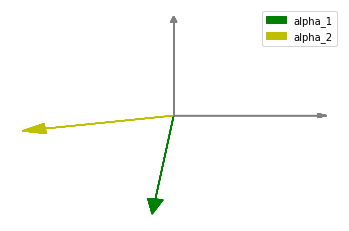

In [ ]:
import matplotlib.patches as mpatches
fig3, ax3 = plt.subplots(1, 1)
last_alpha_x1 = 0.0
last_alpha_y1 = 0.0
t = lambda _: _#tqdm
for i in t(range(0, len(messages_over_time), 1)):
    q = min_result.x
    alphax1, alphay1, offset1 = q[:3]
    alphax2, alphay2, offset2 = q[3:]

    s1 = alphax1**2 + alphay1**2
    s2 = alphax2**2 + alphay2**2

    if ((alphax2 - last_alpha_x1)**2 + (alphay2 - last_alpha_y1)**2 < (alphax1 - last_alpha_x1)**2 + (alphay1 - last_alpha_y1)**2):
      alphax1, alphay1, offset1 = q[3:]
      alphax2, alphay2, offset2 = q[:3]

    last_alpha_x1 = alphax1
    last_alpha_y1 = alphay1
    s1 = alphax1**2 + alphay1**2
    s2 = alphax2**2 + alphay2**2
    alphax1 /= s1**0.5 * 2
    alphay1 /= s1**0.5 * 2
    alphax2 /= s2**0.5 * 2
    alphay2 /= s2**0.5 * 2

    ax3.arrow(0.5, 0.5, alphax1, alphay1, color='g', head_width=0.05, length_includes_head=True)  
    ax3.arrow(0.5, 0.5, alphax2, alphay2, color='y', head_width=0.05, length_includes_head=True)

    ax3.arrow(0.5, 0.5, 0.5,0, color='grey', head_width=0.02, length_includes_head=True)
    ax3.arrow(0.5, 0.5, 0,0.5, color='grey', head_width=0.02, length_includes_head=True)
    ax3.axis('off')

green_patch = mpatches.Patch(color='g', label=r'$\alpha_1$')
yellow_patch = mpatches.Patch(color='y', label=r'$\alpha_2$')
plt.legend(handles=[green_patch, yellow_patch])
plt.savefig(Run + '_rotation.png')
plt.savefig(Run + '_rotation.jpeg')
plt.savefig(Run + '_rotation.pdf')

## Plot predicted vs true trajectories

Let's try to reconstruct the trajectories of the particles integrating the motion with the acceleration obtained from the model and comparing it with the simulated trajectories.

In [ ]:
from simulate import make_transparent_color

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
camera = Camera(fig)

for current_model in range(0,len(recorded_models),int(len(recorded_models)/3)):
    i = 4 
    if current_model > len(recorded_models):
        continue

    #Truth:
    cutoff_time = 300
    times = np.array(s.times)[:cutoff_time]
    x_times = np.array(data[i, :cutoff_time])
    masses = x_times[:, :, -1]
    length_of_tail = 75

    #Learned:
    e = edge_index.cuda()
    ogn.cpu()
    if current_model > -1:
        ogn.load_state_dict(recorded_models[current_model])
    else:
        # Random model!
        ogn = OGN(mod.n_f, mod.msg_dim, mod.dim, dt=0.1, hidden=mod.hidden_dim, edge_index=get_edge_index(n, sim), aggr=mod.aggr).cuda()
    ogn.cuda()
    
    def odefunc(y, t=None):
        y = y.reshape(4, 6).astype(np.float32)
        cur = Data(
            x=torch.from_numpy(y).cuda(),
            edge_index=e
        )

        dx = y[:, 2:4] 
        dv = ogn.just_derivative(cur).cpu().detach().numpy() 
        dother = np.zeros_like(dx)
        return np.concatenate((dx, dv, dother), axis=1).ravel()

    datai = odeint(odefunc, (np.asarray(x_times[0]).ravel()), times).reshape(-1, 4, 6)
    x_times2 = np.array(datai)

    d_idx = 10
    for t_idx in range(d_idx, cutoff_time, d_idx):
        start = max([0, t_idx-length_of_tail])
        ctimes = times[start:t_idx]
        cx_times = x_times[start:t_idx]
        cx_times2 = x_times2[start:t_idx]
        for j in range(n):
            rgba = make_transparent_color(len(ctimes), j/n)
            ax[0].scatter(cx_times[:, j, 0], cx_times[:, j, 1], s=1, color=rgba)
            ax[1].scatter(cx_times2[:, j, 0], cx_times2[:, j, 1], s=1, color=rgba)
            black_rgba = rgba
            black_rgba[:, :3] = 0.75
            ax[1].scatter(cx_times[:, j, 0], cx_times[:, j, 1], s=1, color=black_rgba, zorder=-1)

        for k in range(2):
            ax[k].set_xlim(-1, 3)
            ax[k].set_ylim(-3, 1)
        plt.tight_layout()
        camera.snap()


plt.close()
HTML(camera.animate().to_jshtml())

# Symbolic Regression

After training the network on the data and analyzing the result, we exploit the physical considerations made on the most significant message to obtain an explicit form of the interaction between two nodes. To do this it's possible to use the symbolic regression method within the PySR package.

'best_message' is the message I'll study, the one with the best valiidation loss.

In [ ]:
best_message = np.argmax([np.std(messages_over_time[int(best_val)]['e%d'%(i,)]) for i in range(mod.msg_dim)])
messages_over_time[int(best_val)][['e%d'%(best_message,), 'dx', 'dy', 'r', 'm1', 'm2']]

e57        dx        dy         r        m1        m2
0     -0.168454  0.919987  0.281933  0.962217  5.785905  0.836671
1      0.714651  1.512071  1.784163  2.338717  5.785905  0.770745
2     -0.383343  1.410453 -0.649252  1.552709  5.785905  0.800204
3     -0.011850 -0.919987 -0.281933  0.962217  0.836671  5.785905
4      0.673726  0.592084  1.502230  1.614701  0.836671  0.770745
...         ...       ...       ...       ...       ...       ...
11995  0.265163  0.433298 -0.436672  0.615166  1.684291  3.957689
11996  0.245085 -0.467626  1.289654  1.371817  1.684291  0.415826
11997 -1.190843 -0.620728 -1.564307  1.682961  0.415826  0.464730
11998 -1.377681  0.900923 -1.726326  1.947271  0.415826  3.957689
11999 -0.453102  0.467626 -1.289654  1.371817  0.415826  1.684291

[12000 rows x 6 columns]

## PySR and Julia 

[PySR and Julia](https://github.com/MilesCranmer/PySR)
[PySR demo](https://colab.research.google.com/github/MilesCranmer/PySR/blob/master/examples/pysr_demo.ipynb)

PySR is a symbolic regression algorithm written in the Julia environment and uses regularized evolution, simulated annealing and gradient free optimization to find the best function that approximates the data. The output messages of the first MLP related to all particle pairs of all simulations are passed to PySR and fitted. Unlike of a normal regressor that given a specific function looks for the best parameters, this algorithm starting from a set of operators algebraic and finite parameter, identifies which combination of them best represents the data. So it constructs a function starting from nothing.

For this it is essential that the inductive bias is able to force the representation correctly. Indeed, as far as PySR can be performant if the data is wrong, we will never get the correct analytic expression.

In [ ]:
import pysr
from pysr import PySRRegressor
if RunColab == True:
    pysr.install(precompile=False)  # We don't precompile in colab because compiled modules are incompatible static Python libraries:
else:
    pysr.install() #It could take some time to install

/home/bernardo/.local/lib/python3.10/site-packages/pysr/julia_helpers.py:149: UserWarning: `torch` was loaded before the Julia instance started. This may cause a segfault when running `PySRRegressor.fit`. To avoid this, please run `pysr.julia_helpers.init_julia()` *before* importing `torch`. For updates, see https://github.com/pytorch/pytorch/issues/78829
  warnings.warn(


Julia Version 1.9.1
Commit 147bdf428cd (2023-06-07 08:27 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
      Ubuntu 22.04.2 LTS
  uname: Linux 5.19.0-45-generic #46~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Jun 7 15:06:04 UTC 20 x86_64 x86_64
  CPU: AMD Ryzen 7 5800H with Radeon Graphics: 
                 speed         user         nice          sys         idle          irq
       #1-16  3284 MHz      66145 s         55 s      14617 s    1219030 s          0 s
  Memory: 13.496692657470703 GB (1402.484375 MB free)
  Uptime: 8219.26 sec
  Load Avg:  4.19  5.41  3.81
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, znver3)
  Threads: 1 on 16 virtual cores
Environment:
  JULIA_PROJECT = @pysr-0.14.2
  MATHEMATICA_HOME = /usr/local/Wolfram/Mathematica/13.0
  HOME = /home/bernardo
  SNAP_LIBRARY_PATH = /var/lib/snapd/lib/gl:/var/lib/snapd/lib/gl32:/var/lib/snapd/void
  MANDATORY_PATH = /usr/share/gconf/ubuntu.mandatory.path
  DEFAULTS_PATH = /usr/share/gconf/ubuntu.def

[ Info: Julia version info
[ Info: Julia executable: /snap/julia/80/bin/julia
[ Info: Trying to import PyCall...
┌ Info: PyCall is already installed and compatible with Python executable.
│ 
│ PyCall:
│     python: /bin/python3
│     libpython: /usr/lib/x86_64-linux-gnu/libpython3.10.so.1.0
│ Python:
│     python: /bin/python3
└     libpython: 
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
/home/bernardo/.local/lib/python3.10/site-packages/pysr/julia_helpers.py:105: UserWarning: It is recommended to restart Python after installing PySR's dependencies, so that the Julia environment is properly initialized.
  warnings.warn(


To find the best function PySR uses processes similar to those of natural selection ("genetic algorithms") competing various expressions and mutating them. A population of functions is assigned a score or fitness a depending on their ability to represent the dataset. The best individuals are then combined and mutated in an attempt to get a better version.

In genetic programming individuals are represented by binary trees and the "fitness" of each expression is defined in terms of simplicity (i.e. number of nodes in the tree) and data accuracy (MSE between expected and obtained data). One iteration of the search cycle of the best function can be schematized as follows:

- At first, a population of P randomly generated individuals is created;
- S trees among the P are chosen randomly, the best of these is called parent;
- From the parent a tree called child is built by mutation;
- The child is reinserted into the population if its fitness is better than that of the oldest member.

Since theoretically the PySR compound function has no limit on the number of terms it can contain the risk of overfitting is very high. To overcome this problem, the best function is identified through a score.

## Model to use in PySR

Let's define the model to use by assigning the operators to search for and the number of iterations to repeat in an attempt to find the best function.
We assigned the minimum number of operators to use specific to the type of interaction I'm looking in ordr to have greater efficiency on the specific problem.

In [ ]:
default_pysr_params = dict(
    populations=30,
    model_selection="best",   #selects the candidate model with the highest score among expressions with a loss better than at least 1.5x the most accurate model.
)

model_pysr = PySRRegressor(
    niterations= 30,
    binary_operators=["plus", "sub", "mult", "div"],
    unary_operators=["cube", "square"],
    **default_pysr_params
)

In [ ]:
x = messages_over_time[int(best_val)][['dx', 'dy', 'r', 'm1', 'm2']] # Fit Parameters
y = messages_over_time[int(best_val)][['e%d'%(best_message,)]] #Values that I want to approximate with the function

model_pysr.fit(x,y)

/home/bernardo/.local/lib/python3.10/site-packages/pysr/sr.py:1296: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
/home/bernardo/.local/lib/python3.10/site-packages/pysr/sr.py:1364: FutureWarning: Index.is_object is deprecated.Use pandas.api.types.is_object_dtype instead
  if X.columns.is_object() and X.columns.str.contains(" ").any():
/home/bernardo/.local/lib/python3.10/site-packages/pysr/sr.py:1796: UserWarning: Note: you are running with more than 10,000 datapoints. You should consider turning on batching (https://astroautomata.com/PySR/options/#batching). You should also reconsider if you need that many datapoints. Unless you have a large amount of noise (in which case you should smooth your dataset first), generally < 10,000 datapoints is enough to find a functional form with symbolic regression. More datapoints will lower the search speed.
  warnings.warn(


Compiling Julia backend...


/home/bernardo/.local/lib/python3.10/site-packages/pysr/julia_helpers.py:218: UserWarning: Julia has already started. The new Julia options {'threads': 16} will be ignored.
  warnings.warn(


Note: you are running with more than 10,000 datapoints. You should consider turning on batching (`options.batching`), and also if you need that many datapoints. Unless you have a large amount of noise (in which case you should smooth your dataset first), generally < 10,000 datapoints is enough to find a functional form.
Started!

Expressions evaluated per second: 3.570e+04
Head worker occupation: 9.2%
Progress: 72 / 900 total iterations (8.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
1           4.910e-01  3.911e-01  dy
3           2.465e-01  3.446e-01  (dy / 1.7129295)
4           2.465e-01  1.191e-07  (dy * square(0.7640647))
5           1.249e-01  6.802e-01  (dy - (dy / r))
7           1.063e-01  8.065e-02  ((dy - (dy / r)) * 1.140732)
8           1.050e-01  1.187e-02  ((dy - (dy / r)) * square(1.140732))
9           1.034e-01  1.584e-02  (((dy - (dy / r)) * 1.0507029

PySRRegressor.equations_ = [
	    pick         score                                           equation   
	0         0.000000e+00                                                 dy  \
	1         3.446062e-01                                   (dy * 0.5837609)   
	2         1.217089e-07                          (dy / square(-1.3088276))   
	3         6.801868e-01                                    (dy - (dy / r))   
	4         9.653616e-02                       ((dy - (dy / r)) * 1.230498)   
	5         1.210208e-02            (dy / cube(1.0117072 + (m1 / cube(r))))   
	6         5.643478e-02  (dy / (1.0097111 + (m1 / square(r + -0.7666098...   
	7   >>>>  6.833766e-01  ((dy - (dy / r)) / (0.5176747 + (m1 * 0.231825...   
	8         6.795198e-03  ((dy - (dy / (r - -0.055852503))) / (0.5176747...   
	9         1.527125e-02  (((dy - (dy / r)) / (0.49325857 + (square(0.51...   
	10        6.969331e-03  ((dy - (dy / (r - cube(-0.055852503 / r)))) / ...   
	11        2.057309e-03  ((dy - (dy / (r - (-0.05531991 / (m1 / 0.20967...   
	12        1.701780e-02  ((dy - (dy / r)) / (0.49325857 + ((0.8255394 *...   
	13        3.335460e-02  ((dy - (dy / r)) / (0.49325857 + ((square(0.82...   
	
	        loss  complexity  
	0   0.491044           1  
	1   0.246490           3  
	2   0.246490           4  
	3   0.124853           5  
	4   0.102931           7  
	5   0.100470           9  
	6   0.094957          10  
	7   0.047945          11  
	8   0.047297          13  
	9   0.046581          14  
	10  0.045936          16  
	11  0.045747          18  
	12  0.044975          19  
	13  0.043500          20  
]

## Choosing best function to use

`model_selection="best"` selects the equation with the max score and prints it. But it is best to look through all the equations manually, select an equation above some MSE threshold, and then use the score to select among that loss threshold.

Here, "score" is defined by:
$$ \text{score} = - \log(\text{loss}_i/\text{loss}_{i-1})/
(\text{complexity}_i - \text{complexity}_{i-1})$$ 

In [ ]:
print('Function with best score:\n',model_pysr.sympy())

Function with best score:
 (dy - dy/r)/(0.23182578*m1 + 0.5176747)


In [ ]:
import pickle as pkl

pkl.dump(model_pysr.sympy, open(Run + '_best_score.pkl', 'wb'))

np.savetxt(Run+'_pysr_summary.txt', np.c_[model_pysr.equations_.loss, model_pysr.equations_.complexity,model_pysr.equations_.score])

/home/bernardo/.local/lib/python3.10/site-packages/pysr/sr.py:1079: UserWarning: raw_julia_state_ cannot be pickled and will be removed from the serialized instance. This will prevent a `warm_start` fit of any model that is deserialized via `pickle.load()`.
  warnings.warn(
